Group members:


-   Ceccon Gioele - 2079425
-   Nardella Gaia
-   Renna Pietro
-   Rocca Valerio - 2094861



# Imports

In [1]:
from xml.dom import pulldom
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score
import time 

# Point Generation

We decided to generate 10000 points: 


1.   5000 belong to class 1 
2.   5000 belong to class -1

In total, only 5% of the samples (equally divided among the two classes) have their true labeled assigned. 



In [119]:
n_points = 6000  # change to 10000

In [120]:
# Set up parameters for the L shape
mu1 = np.array([-2, -5])
mu2 = np.array([2, -1])
mu3 = np.array([2, 5])
mu4 = np.array([-2, 2])
#mu1 = np.array([-1, -4])
#mu2 = np.array([1, 0])
#mu3 = np.array([1, 4])
#mu4 = np.array([-1, 1])
sigma1 = np.array([[7, 0], [0, 0.5]])
sigma2 = np.array([[0.5, 0], [0, 4]])  # Modified standard deviation for sample 2
sigma3 = np.array([[7, 0], [0, 0.5]])
sigma4 = np.array([[0.5, 0], [0, 4]])  # Modified standard deviation for sample 4
weights = [0.25, 0.25, 0.25, 0.25]

In [121]:
# Generate random points in the L shape using the Bivariate Gaussian Mixture Distribution
samples1 = np.random.multivariate_normal(mu1, sigma1, int(n_points * weights[0]))
samples2 = np.random.multivariate_normal(mu2, sigma2, int(n_points * weights[1]))
samples3 = np.random.multivariate_normal(mu3, sigma3, int(n_points * weights[2]))
samples4 = np.random.multivariate_normal(mu4, sigma4, int(n_points * weights[3]))

In [122]:
# Assign class labels to the samples
# class1 = np.concatenate((samples2, samples1))
class1 = np.concatenate((samples2, samples1))
class1 = np.c_[class1, np.zeros(len(class1))]
count = 0
true_unlab = []
for i in class1:
    if count == 19:
        count = 0
        i[2] = 1
    else: 
      true_unlab.append(1)
    count += 1

class2 = np.concatenate((samples3, samples4))
class2 = np.c_[class2, np.zeros(len(class2))]
count = 0
for i in class2:
    if count == 19:
        count = 0
        i[2] = -1
    else: 
      true_unlab.append(-1)
    count += 1

# Combine the samples of all three classes
all_samples = np.concatenate((class1, class2))

In [123]:
# Split the samples based on their class label
unlabeled_samples = all_samples[all_samples[:, 2] == 0]
class1_samples = all_samples[all_samples[:, 2] == 1]
class2_samples = all_samples[all_samples[:, 2] == -1]

In [124]:
# Labeled matrix
labeled_samples = np.concatenate((class1_samples, class2_samples))

In [125]:
# Assign random label to unlabeled units
random_unlabeled = np.copy(unlabeled_samples)
random_unlabeled[:, 2] = np.random.choice([-1, 1], size=(random_unlabeled.shape[0]), p=[0.5, 0.5])

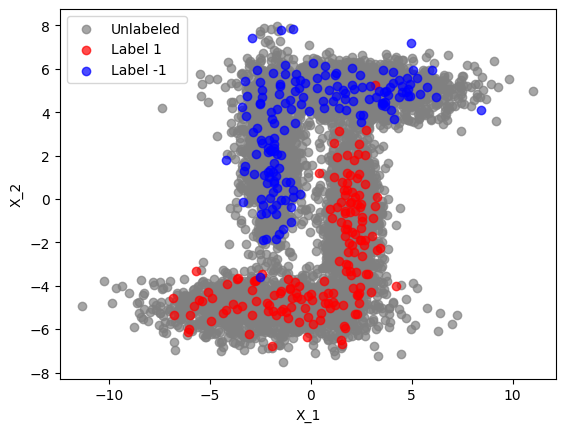

In [126]:
# Plot the samples of each class with a different color and marker
plt.scatter(unlabeled_samples[:, 0], unlabeled_samples[:, 1], color='grey', label='Unlabeled', alpha=0.7)
plt.scatter(class1_samples[:, 0], class1_samples[:, 1], color='red', label='Label 1', alpha=0.7)
plt.scatter(class2_samples[:, 0], class2_samples[:, 1], color='blue', label='Label -1', alpha=0.7)

# Add legend and axis labels
plt.legend()
plt.xlabel('X_1')
plt.ylabel('X_2')

# Show the plot
plt.show()

In [127]:
print(f"There are {len(labeled_samples)} labeled instances: {np.round(((len(labeled_samples)/len(all_samples))*100),1)}% of the total.")

There are 314 labeled instances: 5.2% of the total.


# Similarity function and weights computation

Since the points are drawn from a 2D space, we choose to adopt theinverse multiquadratic kernel as similarity function:
$$k(\mathbf{x}_i,\mathbf{x}_j) = \sum_{d=1}^{D}\frac{1}{\sqrt{(x_{i,d}-x_{j,d})^2 + c^2}}$$

In [128]:
def inverse_multiquadratic_kernel(p1, p2, c=0.5):
    """
    Computes the inverse multiquadratic kernel between two 2D points.

    Args:
    p1: A numpy array of shape (2,) containing the first 2D point.
    p2: A numpy array of shape (2,) containing the second 2D point.
    c: A scalar value that controls the strength of the kernel.

    Returns:
    A scalar value representing the inverse multiquadratic kernel between the two points.
    """
    # Compute the Euclidean distance between the points
    dist = np.sqrt(np.sum((p1 - p2) ** 2))

    # Compute the inverse multiquadratic kernel
    kernel = 1.0 / np.sqrt(dist ** 2 + c ** 2)

    return kernel

In [129]:
#def min_max_normalize_matrix(matrix):
#    min_val = np.min(matrix)
#    max_val = np.max(matrix)
#    return (matrix - min_val) / (max_val - min_val)

In [130]:
w = np.zeros((np.shape(unlabeled_samples)[0], np.shape(labeled_samples)[0]))
w_bar = np.zeros((np.shape(unlabeled_samples)[0], np.shape(unlabeled_samples)[0]))

# similarity matrix unlabeled-labeled
for row in range(np.shape(w)[0]):
    for col in range(np.shape(w)[1]):
        #w[row, col] = np.linalg.norm(unlabeled_samples[row, :2] - labeled_samples[col, :2], ord = 2)
        w[row, col] = inverse_multiquadratic_kernel(unlabeled_samples[row, :2],labeled_samples[col, :2])

# similarity matrix unlabeled-unlabeled
for row in range(np.shape(w_bar)[0]):
    for col in range(np.shape(w_bar)[1]):
        #w_bar[row, col] = np.linalg.norm(unlabeled_samples[row, :2] - unlabeled_samples[col, :2], ord = 2)
        w_bar[row, col] = inverse_multiquadratic_kernel(unlabeled_samples[row, :2],unlabeled_samples[col, :2])

In [131]:
#w = min_max_normalize_matrix(w)
#w_bar = min_max_normalize_matrix(w_bar)

# Lipschitz constant

If f is twice continuously differentiable, then the Lipschitz constant can be estimated as the maximum eigenvalue of the Hessian matrix $\nabla^2 f$ at any point in the domain of f. Specifically, the Lipschitz constant L is given by:
$$ L = \|\nabla^2 f(x)\| $$

Thus, we can use the maximum eigenvalue of $\nabla^2 f$ to estimate L.

In this problem, the Hessian matrix is a diagonal matrix positive-definite.

In [132]:
def hessian(w=w, w_bar=w_bar):
  dim = np.shape(unlabeled_samples)[0]
  h = np.zeros((dim,dim))

  for i in range(dim):
    h[i,i] = 2 * (np.sum(w[i,:]) + np.sum(w_bar[i,:]))

  return h


In [133]:
def compute_L(hessian):
  eigenvalues = np.linalg.eigvals(hessian)
  return np.max(np.abs(eigenvalues))

In [134]:
h = hessian()
L = compute_L(h)
print(L)

3816.3643744745987


# Gradient Methods

In [150]:
# Variables 4 gradient
epsilon = 1e-5
epochs = 50
check = 5

In [151]:
# Threshold selector
def threshold_sel(y_lab_norm):
    y_lab_out = np.copy(y_lab_norm)
    y_lab_out[y_lab_out < 0] = -1
    y_lab_out[y_lab_out >= 0] = 1
    return y_lab_out

In [152]:
# Plot the missclassified ad correctly classified uits
def miss_plot(unlab_grad, unlab_samples = unlabeled_samples, unlab_true = true_unlab):
  # Output labels
  unlab_labs = threshold_sel(unlab_grad)
  # Split in two matrices to plot
  for i in range(np.shape(unlab_samples)[0]):
    unlab_samples[i,2] = unlab_labs[i]
  unlab_true = np.array(unlab_true)
  unlab_samples_tp = unlab_samples[(unlab_samples[:, 2] == 1) & (unlab_samples[:, 2] == unlab_true)]
  unlab_samples_tn = unlab_samples[(unlab_samples[:, 2] == -1) & (unlab_samples[:, 2] == unlab_true)]
  unlab_samples_fp = unlab_samples[(unlab_samples[:, 2] == 1) & (unlab_samples[:, 2] != unlab_true)]
  unlab_samples_fn = unlab_samples[(unlab_samples[:, 2] == -1) & (unlab_samples[:, 2] != unlab_true)]
  
  # Plot the samples of each class with a different color and marker
  plt.scatter(unlab_samples_tp[:, 0], unlab_samples_tp[:, 1], color='red', label='True 1', alpha=0.7)
  plt.scatter(unlab_samples_tn[:, 0], unlab_samples_tn[:, 1], color='blue', label='True -1', alpha=0.7)
  plt.scatter(unlab_samples_fp[:, 0], unlab_samples_fp[:, 1], color='orange', label='False 1', alpha=0.7)
  plt.scatter(unlab_samples_fn[:, 0], unlab_samples_fn[:, 1], color='cyan', label='False -1', alpha=0.7)

  # Add legend and axis labels
  plt.legend()
  plt.xlabel('X_1')
  plt.ylabel('X_2')

  # Show the plot
  return(plt.show())


In [153]:
# Plot accuracy vs epochs
def acc_epochs_plot(y_list, true_unlab = true_unlab, check = check):
  #acc_list = []
  acc_list = y_list
  print(acc_list)
  #for i in y_list:
   # acc = accuracy_score(true_unlab, threshold_sel(i))
    #print(acc)
    #acc_list.append(acc)

  epochs_array = np.arange(0, check * len(acc_list), check)
  plt.plot(epochs_array, acc_list, marker = ".")

  # Set the plot title and labels
  plt.title('Accuracy vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

## Gradient Descent

In [154]:
def gradient(lab_samples, unlab_samples, w=w, w_bar=w_bar):
    grads = []
    for j in range(np.shape(unlab_samples)[0]):  # Da 0 a 947
        grad = 0
        for i in range(np.shape(lab_samples)[0]):
            grad += 2 * w[j][i] * (unlab_samples[j][2] - lab_samples[i][2])
        for i in range(np.shape(unlab_samples)[0]):
            grad += w_bar[j][i] * (unlab_samples[j][2] - unlab_samples[i][2])
        grads.append(grad) #/ (np.shape(lab_samples)[0] + np.shape(unlab_samples)[0])) #GRADIENT+NORMALIZATION
    return np.array(grads)

In [155]:
def gradient_descent(lab_samples, unlab_samples, alpha=1/L, epochs=epochs, epsilon=epsilon, check=check):
    y_lab = np.copy(unlab_samples)

    y_list = []
    time_list = []

    start_time = time.time()

    for i in range(epochs):
        grads = gradient(lab_samples, y_lab)

        norm = np.linalg.norm(grads)
        if  norm < epsilon:
          print(f"The norm of the gradient at iteration {i} is: {norm}") 
          break

        y_lab[:,2] -= alpha * grads
        

        if(i % check == 0):
          print(norm)
          y_list.append(accuracy_score(true_unlab, threshold_sel(y_lab[:,2])))
          elapsed_time = time.time() - start_time
          time_list.append(elapsed_time)

    return y_lab[:,2], np.array(y_list), np.array(time_list)

In [156]:
%%time
y_lab_gd, y_list_gd, time_list_gd = gradient_descent(labeled_samples, random_unlabeled)
y_lab_gd_p = threshold_sel(y_lab_gd)
print(f"Accuracy for Gradient Descent: {accuracy_score(true_unlab, y_lab_gd_p)}")
print("Number of 1 in Gradient Descent {}".format(np.sum(y_lab_gd_p == 1) / len(y_lab_gd_p)))
print("Number of -1 in Gradient Descent {}".format(np.sum(y_lab_gd_p == -1) / len(y_lab_gd_p)))


0.49472388322194866
0.8499824129440732
0.9606049947238833
0.9683432993316918
0.9693985226873022
0.969750263805839
0.968870911009497
0.968870911009497
0.9690467815687653
0.9686950404502286
Accuracy for Gradient Descent: 0.9685191698909602
Number of 1 in Gradient Descent 0.48927189588462894
Number of -1 in Gradient Descent 0.5107281041153711
CPU times: user 28min 18s, sys: 3.59 s, total: 28min 22s
Wall time: 28min 34s


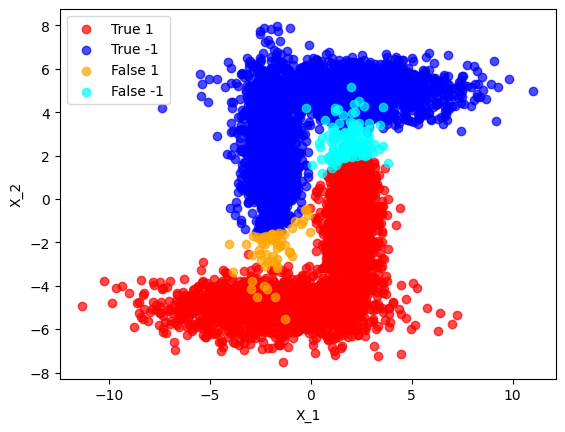

In [157]:
miss_plot(y_lab_gd)

[0.49472388 0.84998241 0.96060499 0.9683433  0.96939852 0.96975026
 0.96887091 0.96887091 0.96904678 0.96869504]


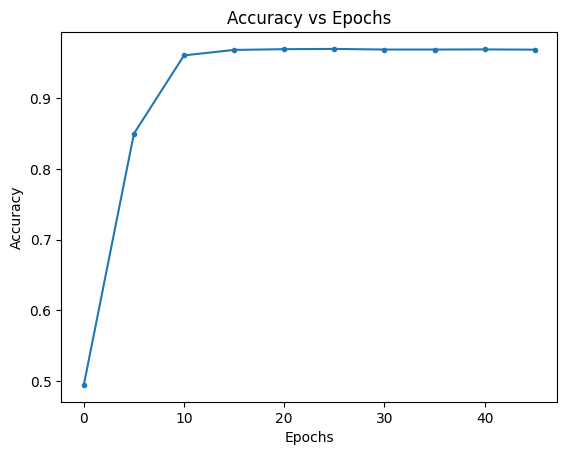

In [158]:
acc_epochs_plot(y_list_gd)

## Randomized BCGD

In [159]:
def rand_gradient(lab_samples, unlab_samples, w=w, w_bar=w_bar):
    grads = np.zeros(np.shape(unlabeled_samples)[0])
    j = np.random.randint(0, np.shape(unlab_samples)[0])
    j = int(j)
    grad = 0
    for i in range(np.shape(lab_samples)[0]):
        grad += 2 * w[j][i] * (unlab_samples[j][2] - lab_samples[i][2])
    for i in range(np.shape(unlab_samples)[0]):
        grad += w_bar[j][i] * (unlab_samples[j][2] - unlab_samples[i][2])
    grads[j] = grad  # / (np.shape(lab_samples)[0] + np.shape(unlab_samples)[0])
    return grads

In [160]:
def rand_bcgd(lab_samples, unlab_samples, alpha=1/L, epochs=100*epochs, epsilon=epsilon, check=100*check):
    y_lab = np.copy(unlab_samples)

    y_list = []
    time_list = []

    start_time = time.time()

    for i in range(epochs):
        grads = rand_gradient(lab_samples, y_lab)

        norm = np.linalg.norm(grads)
        if  norm < epsilon: 
          print(f"The norm of the gradient at iteration {i} is: {norm}")
          break

        y_lab[:, 2] -= alpha * grads

        if(i % check == 0):
          print(f"The norm of the gradient at iteration {i} is: {norm}")
          y_list.append(y_lab[:,2])
          elapsed_time = time.time() - start_time
          time_list.append(elapsed_time)

    return y_lab[:,2], y_list, time_list

In [161]:
%%time
y_lab_rand_bcgd, y_list_rand_bcgd, time_list_rand_bcgd = rand_bcgd(labeled_samples, random_unlabeled)
y_lab_rand_bcgd_p = threshold_sel(y_lab_rand_bcgd)
print("Accuracy for Randomized BCGD")
print(accuracy_score(true_unlab, y_lab_rand_bcgd_p))
print("Frequency of 1 in Randomized BCGD {}".format(np.sum(y_lab_rand_bcgd_p == 1) / len(y_lab_rand_bcgd_p)))
print("Frequency of -1 in Randomized BCGD {}".format(np.sum(y_lab_rand_bcgd_p == -1) / len(y_lab_rand_bcgd_p)))


The norm of the gradient at iteration 0 is: 1882.4910477539872
The norm of the gradient at iteration 500 is: 931.490628586159
The norm of the gradient at iteration 1000 is: 1847.1978685852273
The norm of the gradient at iteration 1500 is: 2048.4393889209373
The norm of the gradient at iteration 2000 is: 974.5836442968499
The norm of the gradient at iteration 2500 is: 1283.2396259533118
The norm of the gradient at iteration 3000 is: 1506.2470105790044
The norm of the gradient at iteration 3500 is: 1890.8472210032508
The norm of the gradient at iteration 4000 is: 1785.4039299209483
The norm of the gradient at iteration 4500 is: 1382.0146578321408
Accuracy for Randomized BCGD
0.49560323601829054
Frequency of 1 in Randomized BCGD 0.5073865634892719
Frequency of -1 in Randomized BCGD 0.4926134365107281
CPU times: user 30.6 s, sys: 80.8 ms, total: 30.7 s
Wall time: 30.9 s


## Gauss-Southwell BCGD

In [162]:
def max_gradient(lab_samples, unlab_samples):
    grad = gradient(lab_samples, unlab_samples)
    j = np.argmax(np.abs(gradient(lab_samples, unlab_samples)))
    grads = np.zeros(np.shape(unlabeled_samples)[0])
    grads[j] = grad[j]
    return grads

In [163]:
def gs_bcgd(lab_samples, unlab_samples, alpha=1/L, epochs=epochs, epsilon=epsilon, check=check):
    y_lab = np.copy(unlab_samples)

    y_list = []
    time_list = []

    start_time = time.time()

    for i in range(epochs):
        grads = max_gradient(lab_samples, y_lab)

        norm = np.linalg.norm(grads)
        if  norm < epsilon:
          print(f"The norm of the gradient at iteration {i} is: {norm}") 
          break

        y_lab[:, 2] -= alpha * grads

        if(i % check == 0):
          print(f"The norm of the gradient at iteration {i} is: {norm}")
          y_list.append(y_lab[:,2])
          elapsed_time = time.time() - start_time
          time_list.append(elapsed_time)

    return y_lab[:,2], y_list, time_list

In [164]:
%%time
y_lab_gs_bcgd, y_list_gs_bcgd, time_list_gs_bcgd = gs_bcgd(labeled_samples, random_unlabeled)
y_lab_gs_bcgd_p = threshold_sel(y_lab_gs_bcgd)
print("Accuracy for Gauss Sauthwell BCGD")
print(accuracy_score(true_unlab, y_lab_gs_bcgd_p))

print("Frequency of 1 in Gauss Sauthwell BCGD {}".format(np.sum(y_lab_gs_bcgd_p == 1) / len(y_lab_gs_bcgd_p)))
print("Frequency of -1 in Gauss Sauthwell BCGD {}".format(np.sum(y_lab_gs_bcgd_p == -1) / len(y_lab_gs_bcgd_p)))

The norm of the gradient at iteration 0 is: 2068.9967359625216
The norm of the gradient at iteration 5 is: 2072.683581367081
The norm of the gradient at iteration 10 is: 2074.045508806343


KeyboardInterrupt: ignored